In [52]:
!pip install neurokit2 --quiet
!pip install tqdm --quiet
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1 --quiet

In [121]:
from tensorflow.keras.optimizers import AdamW
from sklearn.utils.class_weight import compute_class_weight

In [116]:
from sklearn.metrics import confusion_matrix, classification_report

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LeakyReLU,BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.feature_selection import SelectKBest, f_classif
from copy import deepcopy
import neurokit2 as nk
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from imblearn.over_sampling import SMOTE


In [54]:
def extract_all_ecg_data(data_dir):
    all_data = []

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.pkl'):
                    file_path = os.path.join(folder_path, file)

                    with open(file_path, 'rb') as f:
                        data = pickle.load(f, encoding='latin1')

                    if 'ECG' in data['signal']['chest']:
                        ecg = data['signal']['chest']['ECG']
                        labels = data['label']
                        min_len = min(len(ecg), len(labels))

                        df = pd.DataFrame(ecg[:min_len], columns=['ECG'])
                        df['label'] = labels[:min_len]
                        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

In [55]:
data_dir = "/kaggle/input/wesad-full-dataset/WESAD"
ecg_df = extract_all_ecg_data(data_dir)

In [56]:
ecg_df.head()

,ECG,label
0,-0.170883,0
1,-0.152618,0
2,-0.131973,0
3,-0.118790,0
4,-0.111740,0


In [57]:
ecg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60807600 entries, 0 to 60807599
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ECG     float64
 1   label   int32  
dtypes: float64(1), int32(1)
memory usage: 695.9 MB


In [58]:
ecg_df["label"].value_counts()

label
0    27654897
1    12327702
4     8264199
2     6976201
3     3902501
7      576802
6      552998
5      552300
Name: count, dtype: int64

In [60]:
# Keep original label for clarity
ecg_df['original_label'] = ecg_df['label']

# Create binary stress label: 1 = stress, 0 = not-stress
ecg_df['label'] = ecg_df['original_label'].apply(lambda x: 1 if x == 2 else (0 if x in [1, 3, 4] else None))

ecg_df = ecg_df.dropna(subset=['label'])

ecg_df['label'] = ecg_df['label'].astype(int)


In [61]:
#ecg_df['label'] = (ecg_df['label'] >= 1).astype(int)

In [62]:
ecg_df.describe()

,ECG,label,original_label
count,3.147060e+07,3.147060e+07,3.147060e+07
mean,1.124109e-03,2.216736e-01,2.257485e+00
std,2.653213e-01,4.153726e-01,1.224675e+00
min,-1.500000e+00,0.000000e+00,1.000000e+00
25%,-8.843994e-02,0.000000e+00,1.000000e+00
50%,-2.458191e-02,0.000000e+00,2.000000e+00
75%,3.291321e-02,0.000000e+00,4.000000e+00
max,1.499954e+00,1.000000e+00,4.000000e+00


In [63]:
ecg_df['label'].value_counts()

label
0    24494402
1     6976201
Name: count, dtype: int64

In [64]:
ecg_df['label'].value_counts(normalize=True)

label
0    0.778326
1    0.221674
Name: proportion, dtype: float64

In [65]:
 def extract_ecg_features_from_windows(ecg_series, label_series, sampling_rate=700, window_sec=30, step_sec=15):
    window_size = window_sec * sampling_rate
    step_size = step_sec * sampling_rate

    X_features = []
    y_labels = []
    feature_names = None

    for start in tqdm(range(0, len(ecg_series) - window_size, step_size),desc="Extracting Features"):
        ecg_window = ecg_series[start:start + window_size]
        label_window = label_series[start:start + window_size]

        if len(set(label_window)) > 1:
            continue  # Skip mixed-label windows

        try:
            _, info = nk.ecg_process(ecg_window, sampling_rate=sampling_rate)
            rpeaks = info.get("ECG_R_Peaks", [])
            if len(rpeaks) < 2:
                continue

            features = nk.hrv(rpeaks, sampling_rate=sampling_rate, show=False)

            # On first valid window, define and lock usable columns
            if feature_names is None:
                feature_names = features.columns[features.notna().all()].tolist()

            # Restrict to consistent, non-NaN columns
            features = features[feature_names]

            # Append
            X_features.append(features.iloc[0].values)
            y_labels.append(label_window[0])

        except Exception as e:
            print(f"Skipping window at index {start} due to error: {e}")
            continue

    # Final conversion
    return np.vstack(X_features), np.array(y_labels), feature_names


In [66]:
X, y, feature_names = extract_ecg_features_from_windows(
    ecg_series=ecg_df['ECG'].values,
    label_series=ecg_df['label'].values,
    sampling_rate=700
)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Extracting Features: 100%|██████████| 2996/2996 [17:32<00:00,  2.85it/s]

Feature matrix shape: (2936, 71)
Labels shape: (2936,)


In [67]:
X_df = pd.DataFrame(X)

# Drop columns with any NaN or Inf
X_df = X_df.replace([np.inf, -np.inf], np.nan)
X_df = X_df.dropna(axis=1)

# Convert back to NumPy
X_clean = X_df.values

print(pd.DataFrame(X_clean))

               0           1           2           3         4         5   \
0      818.734694   52.339931   40.752231   41.352415  0.063928  0.049775   
1      847.815126   44.881808   44.849780   45.543809  0.052938  0.052900   
2      856.260504   46.421764   43.301449   43.945902  0.054215  0.050570   
3      888.138528   39.153161   44.367724   45.071810  0.044085  0.049956   
4      887.359307   34.876095   39.496189   40.117914  0.039303  0.044510   
...           ...         ...         ...         ...       ...       ...   
2931  1076.137566  106.633820  127.470562  129.994964  0.099089  0.118452   
2932  1002.019704  143.665832  142.469883  144.719046  0.143376  0.142183   
2933  1003.152709  130.217568  122.476868  124.677188  0.129808  0.122092   
2934  1037.142857  127.189516   87.045222   86.719415  0.122635  0.083928   
2935   977.809524  169.832775  155.680161  158.356439  0.173687  0.159213   

               6        7         8           9   ...        57        58  

In [68]:
import pandas as pd

# X = your features (shape: [n_samples, 70])
# y = your labels

# Select top k features using Fisher Score (ANOVA F-value)
k = 12  # number of features to keep
selector = SelectKBest(score_func=f_classif, k=k)

# Fit selector
X_selected = selector.fit_transform(X_clean, y)

# (Optional) Get the indices of selected features
selected_indices = selector.get_support(indices=True)

# (Optional) If you started with a DataFrame, get column names
selected_feature_names = [f'Feature_{i}' for i in selected_indices]  # adjust if you have column names

print("Selected feature indices:", selected_indices)

Selected feature indices: [ 0  6 10 11 12 14 15 16 28 29 60 62]


In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [122]:
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [123]:
print(X_train.shape, y_train.shape)
print(np.unique(y_train))

(2377, 12) (2377,)
[0 1]


In [96]:
def build_model():
    model = Sequential()
    model.add(Input(shape=(12,)))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LeakyReLU(0.2))
    # Block 1: 64 neurons
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LeakyReLU(negative_slope=0.2))
    
    # Block 2: 32 neurons
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LeakyReLU(negative_slope=0.2))
    
    # Block 3: 16 neurons
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LeakyReLU(negative_slope=0.2))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    return model


In [95]:
model = build_model()
model.compile(optimizer=AdamW(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [89]:
model.summary()

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_500 (Dense)                    │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_375              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_375 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_375 (LeakyReLU)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_501 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_376              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_376 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_376 (LeakyReLU)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_502 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_377              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_377 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_377 (LeakyReLU)          │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_503 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_378              │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_378 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_378 (LeakyReLU)          │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_504 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,505 (52.75 KB)

 Trainable params: 13,025 (50.88 KB)

 Non-trainable params: 480 (1.88 KB)

In [75]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras

class MyCallback(keras.callbacks.Callback):
    def __init__(self,patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        #self.my_model = model
        self.patience = patience 
        self.stop_patience = stop_patience 
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_permission = 1

        # callback variables
        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1  
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf
        self.best_weights = None
        self.initial_weights = None
        self.initial_lr = None

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()
        self.model.optimizer.learning_rate.assign(self.initial_lr)

        '''msg = 'Do you want model to ask you to halt training manually [y/n]?'
        print(msg)
        ans = input('').strip().lower()
        if ans == 'y':
            self.ask_permission = 1
        else:
            self.ask_permission = 0'''

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
        )
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration % 3600) // 60
        seconds = tr_duration % 60

        msg = f'Training finished in {int(hours)}h {int(minutes)}m {seconds:.2f}s'
        print(msg)

        # Restore best weights
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy', 0) * 100
        loss = logs.get('loss', 0)
        msg = f'Processing batch {batch} of {self.batches} - Accuracy: {acc:.2f}% - Loss: {loss:.5f}'
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        if self.count >= self.patience - 1:
            next_lr = lr * self.factor 
            self.model.optimizer.learning_rate.assign(next_lr)
            self.count = 0
            self.stop_count += 1
        else:
            next_lr = lr  
        if isinstance(self.model.optimizer, tf.keras.optimizers.Adam):  # Check if the optimizer is Adam
            self.model.optimizer.learning_rate.assign(next_lr)
            #tf.keras.backend.set_value(self.model.optimizer.learning_rate, next_lr)  # Update the learning rate
        else:
            print("Optimizer is not of type Adam.")

        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        monitor = ''
        pimprov = 0.0
        next_lr = lr

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = 0.0 if epoch == 0 or self.highest_tracc == 0 else (acc - self.highest_tracc) * 100 / self.highest_tracc
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
            else:
                if self.count >= self.patience - 1:
                    next_lr = lr * self.factor
                    self.model.optimizer.learning_rate.assign(next_lr)
                    #tf.keras.backend.set_value(self.model.optimizer.learning_rate, next_lr)
                    self.count = 0
                    self.stop_count += 1
                else:
                    self.count += 1
        else:
            monitor = 'val_loss'
            pimprov = 0.0 if epoch == 0 or self.lowest_vloss == np.inf else (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    next_lr = lr * self.factor
                    self.model.optimizer.learning_rate.assign(next_lr)
                    #tf.keras.backend.set_value(self.model.optimizer.learning_rate, next_lr)
                    self.count = 0
                    self.stop_count += 1
                else:
                    self.count += 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{epoch+1:^8}{loss:^10.3f}{acc*100:^9.2f}{v_loss:^9.3f}{v_acc*100:^9.2f}{lr:^9.5f}{next_lr:^9.5f}{monitor:^10}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count >= self.stop_patience:
            print(f'Training stopped at epoch {epoch+1} after {self.stop_patience} LR adjustments without improvement.')
            self.model.stop_training = True

        '''elif self.ask_epoch is not None and self.ask_permission and (epoch + 1) >= self.ask_epoch:
            print('Enter H to halt training or a number to continue training for that many more epochs:')
            ans = input('').strip()
            if ans.lower() == 'h':
                print(f'Training stopped manually at epoch {epoch + 1}')
                self.model.stop_training = True
            else:
                try:
                    more_epochs = int(ans)
                    self.ask_epoch += more_epochs
                    print(f'Training will continue to epoch {self.ask_epoch}')
                except:
                    print('Invalid input. Training will continue.')'''

In [158]:
def train_model(X_train, X_val, y_train, y_val, model_architecture, loss_function, training_params, learning_rate, optimizer_class,class_weights):
    best_model = None
    best_validation_loss = float('inf')

    kf = KFold(n_splits=91, shuffle=True, random_state=42)

    for fold_index, (train_index, val_index) in enumerate(kf.split(X), 1):
        print(f"Training fold {fold_index}")

        patience = training_params.get('patience', 3)
        stop_patience = training_params.get('stop_patience', 5)
        threshold = training_params.get('threshold', 0.9)
        factor = training_params.get('factor', 0.5)
        ask_epoch = training_params.get('ask_epoch', None)
        batches = training_params.get('batch_size', 16)
        epochs = training_params.get('num_epochs', 50)

       
        model = model_architecture()
        optimizer = optimizer_class(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])
        #model.summary()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=training_params['num_epochs'],
            batch_size=training_params['batch_size'],
            verbose=0,
            callbacks = [MyCallback(patience= patience, stop_patience= stop_patience,
                        threshold= threshold,factor= factor, batches= batches,
                        epochs= epochs, ask_epoch= ask_epoch )],
                        class_weight=class_weights
        )

        val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
        if val_loss < best_validation_loss:
            best_validation_loss = val_loss
            best_model = clone_model(model)
            best_model.set_weights(model.get_weights())
            best_model.compile(optimizer=optimizer_class(learning_rate=learning_rate), loss=loss_function, metrics=["accuracy"])


    print(f"Best validation loss: {best_validation_loss:.4f}")
    return best_model,history

In [159]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [160]:
x_train = X_train.reshape(-1, 12)
y_train = y_train[:len(x_train)] 

In [161]:
training_params = {
    'num_epochs': 50,
    'batch_size': 16
}

#best_model, history = train_model(x_train, X_val, y_train, y_val, build_model, 'binary_crossentropy', training_params, 0.0001, Adam)
best_model,hist = train_model(x_train, X_val, y_train, y_val, build_model, 'binary_crossentropy', training_params, 0.0001, AdamW,class_weights)

Training fold 1
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
   1      0.678     54.73    0.633    70.57   0.00010  0.00010  accuracy    0.00    13.98  
   2      0.580     61.25    0.581    74.34   0.00010  0.00010  accuracy   11.91     0.32  
   3      0.534     65.42    0.563    72.45   0.00010  0.00010  accuracy    6.80     0.32  
   4      0.511     69.46    0.545    74.34   0.00010  0.00010  accuracy    6.17     0.31  
   5      0.483     70.21    0.524    75.47   0.00010  0.00010  accuracy    1.09     0.32  
   6      0.475     71.10    0.496    77.36   0.00010  0.00010  accuracy    1.26     0.31  
   7      0.459     73.16    0.492    77.36   0.00010  0.00010  accuracy    2.90     0.31  
   8      0.453     75.81    0.467    79.25   0.00010  0.00010  accuracy    3.62     0.34  
   9      0.456     75.43    0.450    79.25   0.00010  0.00010  accuracy   -0.50     0.31  
   10     0.459     74.42    0.438    80.38   0.00010  0.00010  

In [162]:
train_score = best_model.evaluate(x_train, y_train)
valid_score = best_model.evaluate(X_val,y_val)
test_score = best_model.evaluate(X_test, y_test)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('_' * 100)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8561 - loss: 0.3376
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8880 - loss: 0.3243 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8700 - loss: 0.3606
Train Loss:  0.3342980146408081
Train Accuracy:  0.8636937141418457
--------------------
Validation Loss:  0.32244181632995605
Validation Accuracy:  0.8716981410980225
--------------------
Test Loss:  0.34830960631370544
Test Accuracy:  0.8673469424247742
____________________________________________________________________________________________________


In [131]:
def plot_training(hist):
        tr_acc = hist.history['accuracy']
        tr_loss = hist.history['loss']
        val_acc = hist.history['val_accuracy']
        val_loss = hist.history['val_loss']
        index_loss = np.argmin(val_loss)
        val_lowest = val_loss[index_loss]
        index_acc = np.argmax(val_acc)
        acc_highest = val_acc[index_acc]
        Epochs = [i+1 for i in range(len(tr_acc))]
        loss_label = f'best epoch= {str(index_loss + 1)}'
        acc_label = f'best epoch= {str(index_acc + 1)}'


        plt.figure(figsize= (20, 8))
        plt.style.use('fivethirtyeight')
        
        plt.subplot(1, 2, 1)
        plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
        plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
        plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
        plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
        plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        print('_' * 50)
        plt.tight_layout
        plt.show()

__________________________________________________


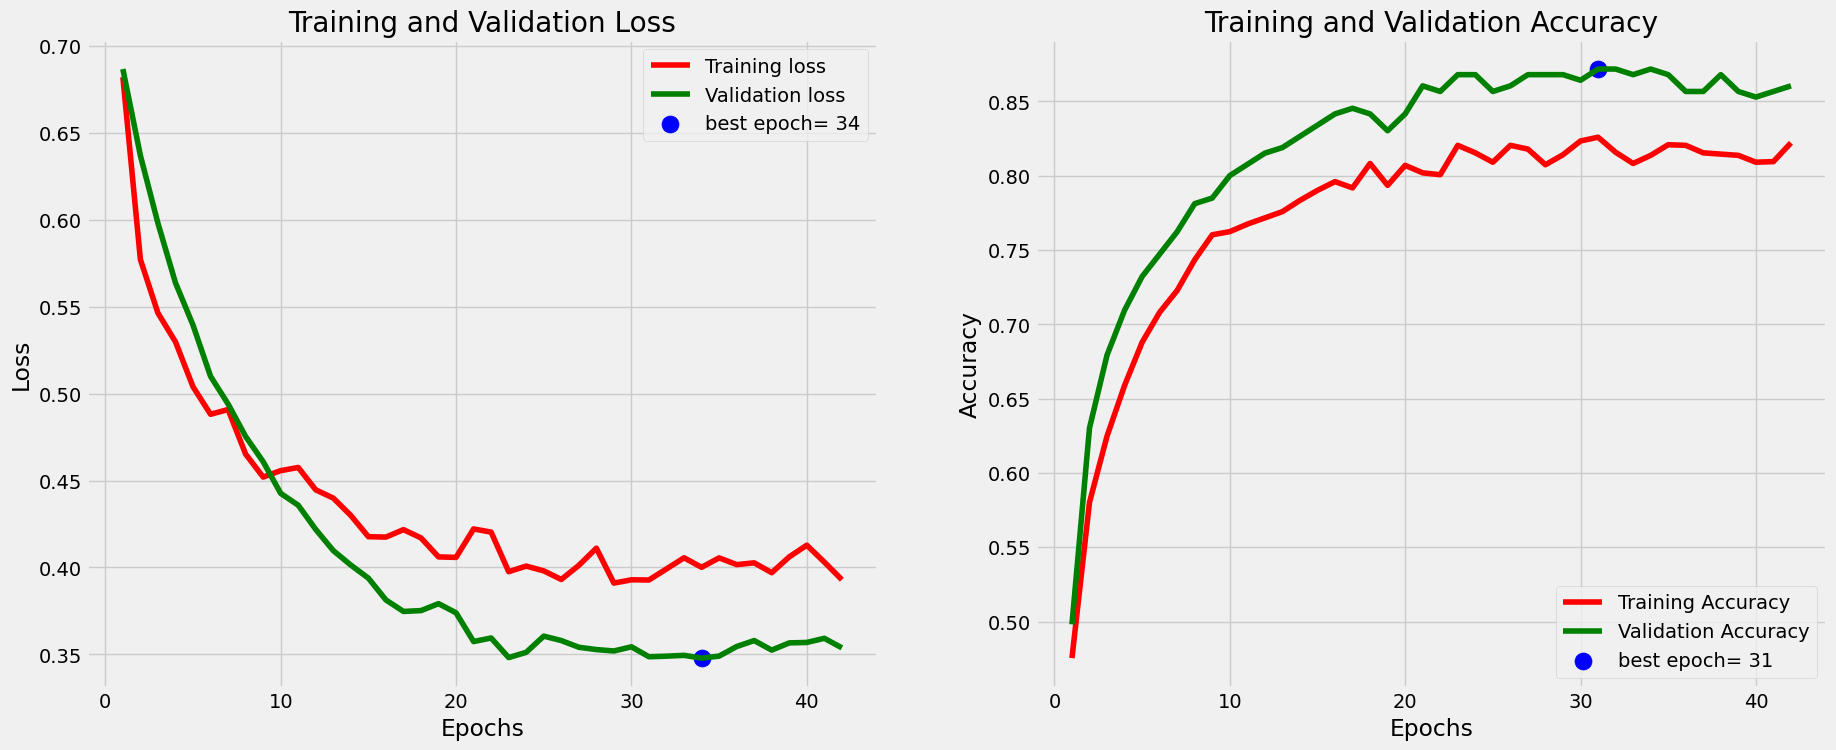

In [163]:
plot_training(hist)

In [164]:
y_pred = best_model.predict(X_test)

# Convert the predicted probabilities to class labels
# pred_label = np.argmax(y_pred, axis =1)

# Get the true class labels from the test data generator
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


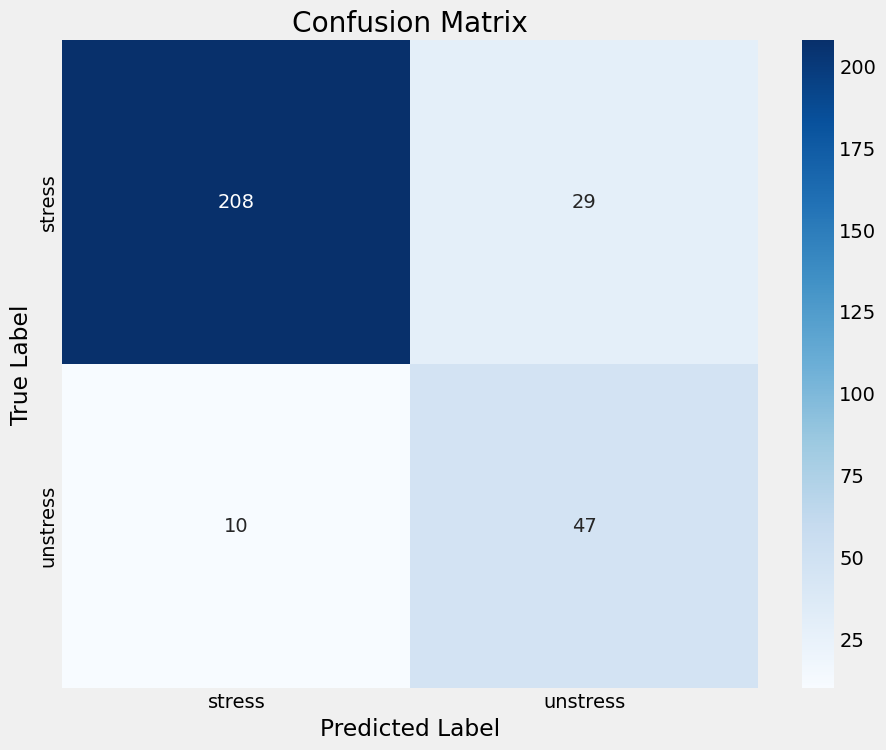

In [165]:
class_names = ["stress","unstress"]

        
        # Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test,y_pred_labels)
        
        # Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

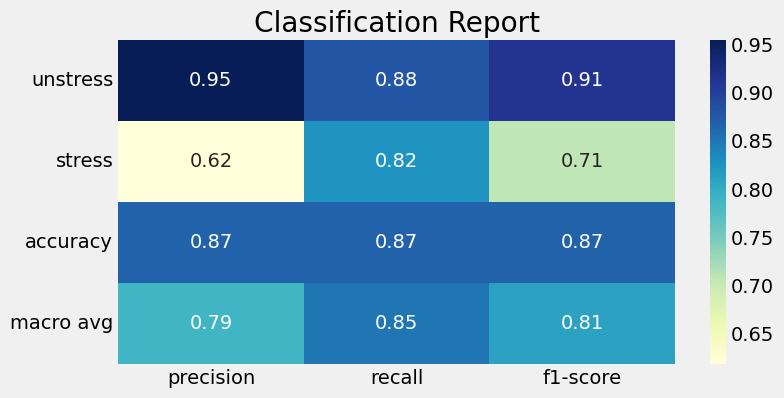

In [166]:
report_dict = classification_report(y_test, y_pred_labels, target_names=["unstress", "stress"], output_dict=True)
 
report_df = pd.DataFrame(report_dict).transpose()


plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report")
plt.show()

Text(0.5, 1.0, 'PCA projection of ECG HRV features')

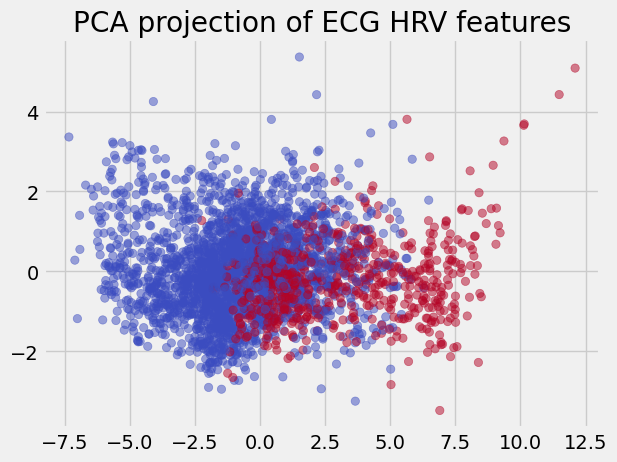

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.title("PCA projection of ECG HRV features")
